## Exercise Extra: Custom Disk Galaxy in DM Halo
### With N-body interaction

In [3]:
%reload_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

import h5py

from main.make_ics import galaxy_ics
from main.nbody_nfw import NBodySimulation
import main.plot_utils as pu

In this bonus exercise, instead of using nearest neighbours algorithm to reduce the computational complexity of the simulation, we will squeeze the potential of our parallel brute-force N-body implementation with a custom number of N bodies. 

For that we need to generate the initial conditions of a galaxy. This is done by means of the `galaxy_ics()` function in the `main/make_ics.py` module. What this function does is the following:
- Given a scale radius for the galaxy, `R_d`, it gets the positions of the bodies following a flat exponential disk distribution in the equatorial plane. Gaussian noise is added to the original positions in each coordinate by specyfying a standard deviation by means of the `pos_std` argument. We set that to 1 kpc.
- It computes the circular velocities and adds noise as before by means of the `vel_std` parameter. But beware! To compute the circular velocities one sets them as $$v\left( r \right) = \sqrt{r \frac{\partial \phi}{\partial r}}$$ with $\phi$ being the potential. But here the potential has two contributions, one coming from the NFW DM halo, $\phi_{\text{NFW}}$, which we can easily calculate; and the other due to the interactions between N-bodies, $\phi_{N}$, which we cannot compute analytically. So we do the following approximation. As $\partial \phi_N / \partial r$ is approximately the mean gravitational field felt by a particle, we set $$v\left( r \right) = \sqrt{r \frac{\partial \phi_{\text{NFW}}}{\partial r} + r g_{\text{mean}}}$$
for each particle. 

The ICs are saved as a `.hdf5` file. 

Let's generate a galaxy this way, with a total mass of $M=5 \times 10^{10} \, \text{M}_\odot$, and $N=20.000$ bodies. 

In [13]:
N = 2e4  # Number of particles
N = int(N)

R_s = 20.0  # Scale radius of the NFW profile (kpc)
R_d = R_s / 4.5  # Scale radius of the disk (kpc)
rho_0 = 5932371.0  # Central density of the NFW profile (Msun/kpc^3)
pos_std = 1  # Noise std for the positions
vel_std = 1  # Noise std for the velocities
total_mass = 5e10  # Total mass of the galaxy (Msun)
G = 4.30091e-6  

sim_folder = f'results/extraa/'
path_ics = f'{sim_folder}ics.hdf5'

galaxy_ics(path_ics, N, R_d, R_s=R_s, rho_0=rho_0, pos_std=pos_std, vel_std=vel_std, total_mass=total_mass)

# Min and max periods are printed to have a reference for the time step

Min period: 0.0006253194816815097
Max period: 1.5804775324339961


We now run the simulation for $T=2.5$ (in code units) and a timse-step $dt=5\times 10 ^{-4}$, wich corresponds to about $5000$ time-steps. We get 600 snapshots. To make it interesteing we **remove the NFW DM Halo** at $t=1.25$. That is, after $t=1.25$ the only interaction is due to the N-bodies, and not the NFW density field. This is unphysical, but revealing, as we expect the galaxy to be no longer rotationally supported.  

In [14]:
path_output = sim_folder + 'output.hdf5'

e = 0.01
T = 2.5
dt = 5e-4
num_snapshots = 600

Sim = NBodySimulation(path_ics, path_output)
Sim.R_s = R_s
Sim.rho_0 = rho_0

Sim.set_time(T, dt, snapshots=num_snapshots)
Sim.set_time_NFW_off(1.25)  # Turn off the NFW profile at approx t=1.25
Sim.estimate_runtime(3)  # We get a runtime estimation for 3 snapshots

Estimated time: 00h 39m 36s
Mean time per step: 4.75e-01 s


We have estimated the time with `estimate_runtime()` and the whole thing should take 40 min. We now run it for real

In [15]:
Sim.run_simulation(e=e)

99.98%
Elapsed time: 1945.06 s


and plot the results as before and we make an animation

Save images time: 56.66 s
Video creation time: 7.24 s
animation saved at results/extraa//video.mp4


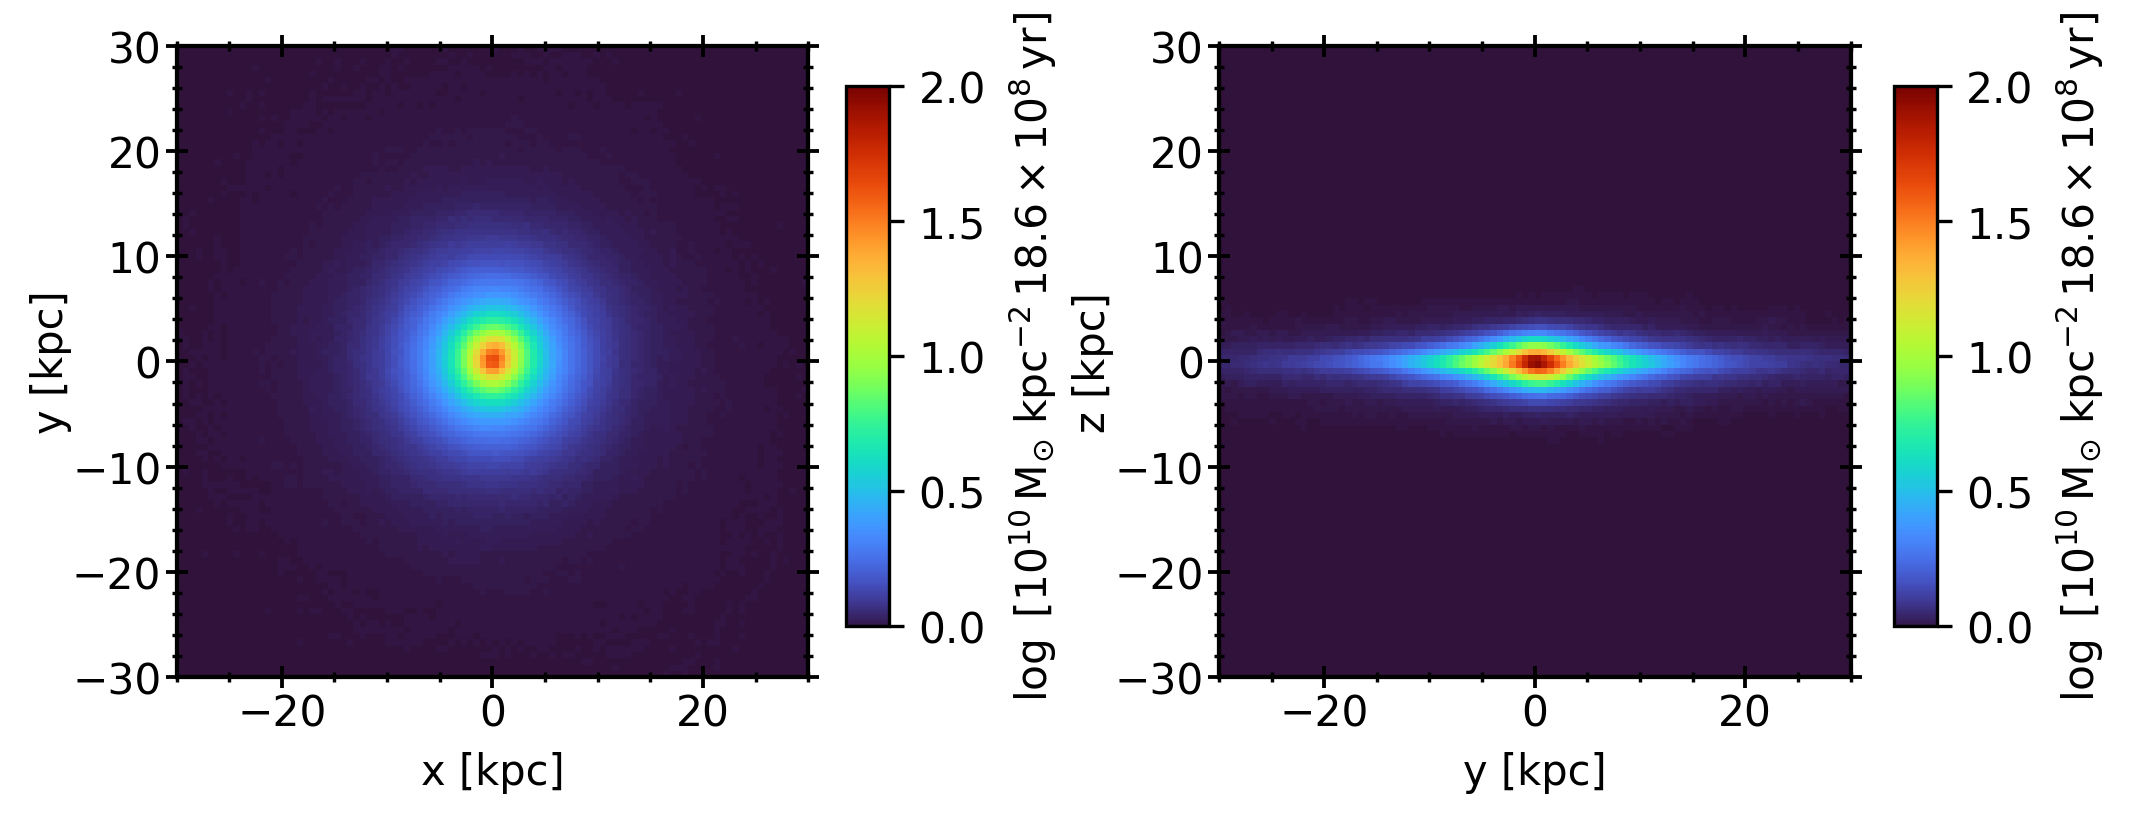

In [34]:
pu.make_animation(path_output, 
                  fig_size=540,
                  marker_size=0.05,
                  lim=R_s*1.25,
                  fps=30,
                  delete_frames=True,)
print(f'animation saved at {sim_folder}/video.mp4')

savepath = 'figures/extra_figure.jpg'
pu.plot_galaxy(path_output, savepath, vmaxs=[2, 2], log=True)

And as a final bonus, we also performed a simulation of a galaxy like the one above, with $N=50.000$ bodies till $T=2.5$ (code units), also with the NFW DM Halo 'turned off' at $t=1.25$. You can see an animation of this simulation (made with with Blender) at 
- https://www.youtube.com/watch?v=APY58UG-HWU&ab_channel=PeRossello

and we can see that after the DM halo disappears the galaxy is no longer rotationally supported, the outer regions spread, and a bar forms (which I'm not sure why it happens)

In [36]:
# Let's just convert the video to gif quickly

import subprocess

def mp4_to_gif(input_file, output_file, quality):
    """
    Converts an MP4 video to GIF using ffmpeg.

    :param input_file: Path to the input MP4 file.
    :param output_file: Path to save the output GIF.
    :param quality: An integer from 1 to 31. Lower is better quality.
    """
    # Ensure the quality is within the valid range
    quality = max(1, min(quality, 31))

    # Construct ffmpeg command
    command = [
        'ffmpeg',
        '-i', input_file,
        '-vf', f'fps=10,scale=320:-1:flags=lanczos',
        '-q:v', str(quality),
        output_file
    ]

    # Run the ffmpeg command
    subprocess.run(command, check=True)

mp4_to_gif(f'{sim_folder}/video.mp4', f'{sim_folder}/video.gif', 20)